In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller



In [2]:
data = pd.read_csv('BITRE_Fatality-Table 1.csv')
data.head()

/var/folders/3l/xh28kn0j7_7d5hh7fgz188940000gn/T/ipykernel_1871/1511047806.py:1: DtypeWarning: Columns (10,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BITRE_Fatality-Table 1.csv')


,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,Age,National Remoteness Areas,SA4 Name 2021,National LGA Name 2021,National Road Type,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,19,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
1,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,9,NaN,NaN,NaN,NaN,No,No,0_to_16,Weekday,Night
2,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,21,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
3,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,45,NaN,NaN,NaN,NaN,No,No,40_to_64,Weekday,Night
4,20243023,Qld,4,2024,Friday,01:00,Single,No,No,No,...,24,Outer Regional Australia,Cairns,Cairns,Local Road,No,No,17_to_25,Weekday,Night


#without Holidays

01:54:54 - cmdstanpy - INFO - Chain [1] start processing
01:54:55 - cmdstanpy - INFO - Chain [1] done processing
01:54:55 - cmdstanpy - INFO - Chain [1] start processing
01:54:55 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023) - Time of day:
Day - MAE: 10.75, MSE: 166.92, MAPE: 15.55%
Forecast vs Actual for first three months of 2024 for Day:
            ds   yhat  yhat_lower  yhat_upper
420 2024-01-01  55.45       36.28       75.50
421 2024-02-01  51.45       32.05       71.15
422 2024-03-01  63.59       44.34       82.75
        Date  Counts
0 2024-01-01      59
1 2024-02-01      72
2 2024-03-01      62

Forecast for Day in 2030:
            ds   yhat  yhat_lower  yhat_upper
493 2030-01-31  47.97       27.16       65.31
494 2030-02-28  59.93       39.57       78.53
495 2030-03-31  50.70       31.85       70.06
496 2030-04-30  52.91       33.58       71.39
497 2030-05-31  53.56       34.39       72.41
498 2030-06-30  52.63       33.01       69.98
499 2030-07-31  49.98       30.95       69.02
500 2030-08-31  57.50       35.54       77.17
501 2030-09-30  53.32       32.82       74.41
502 2030-10-31  56.08       35.98       74.21
503 2030-11-30  60.47       39.11  

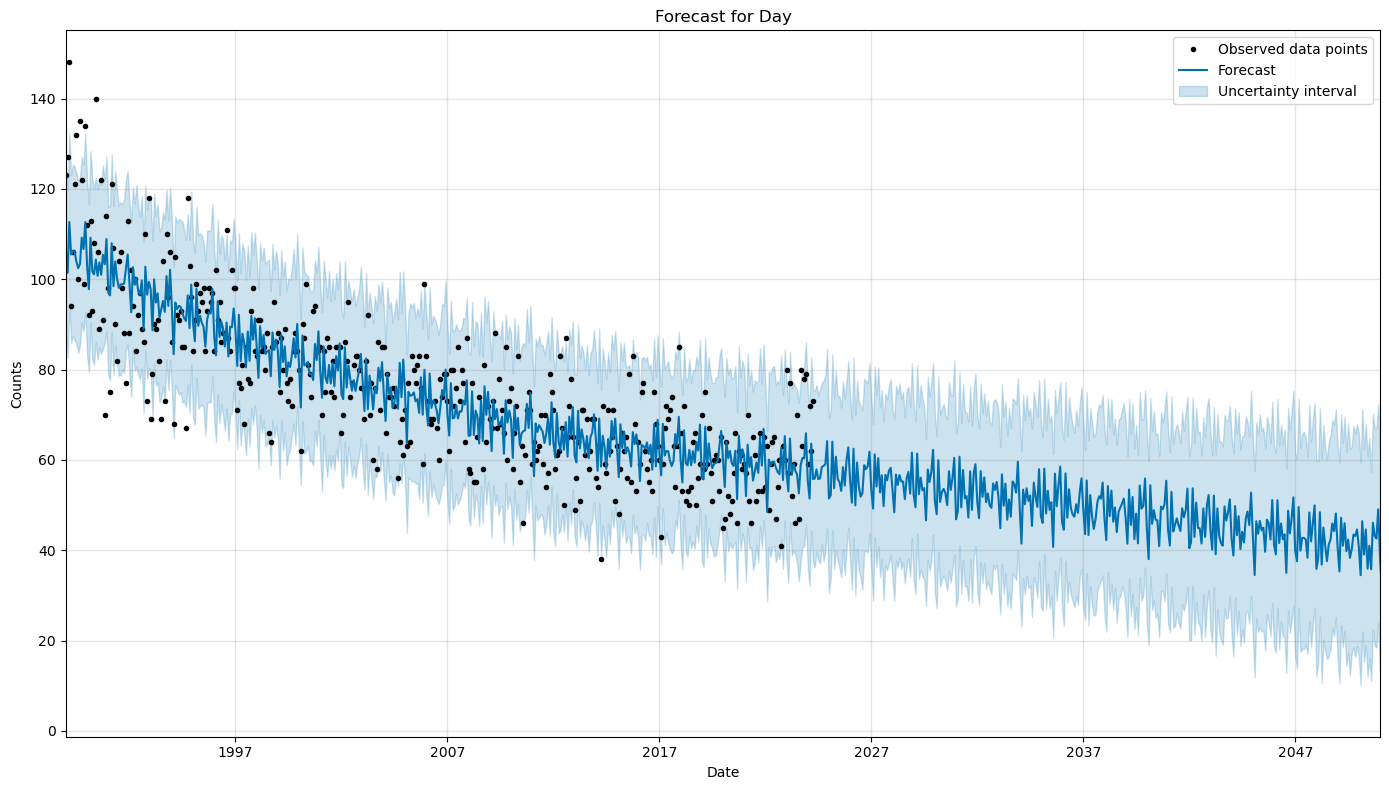

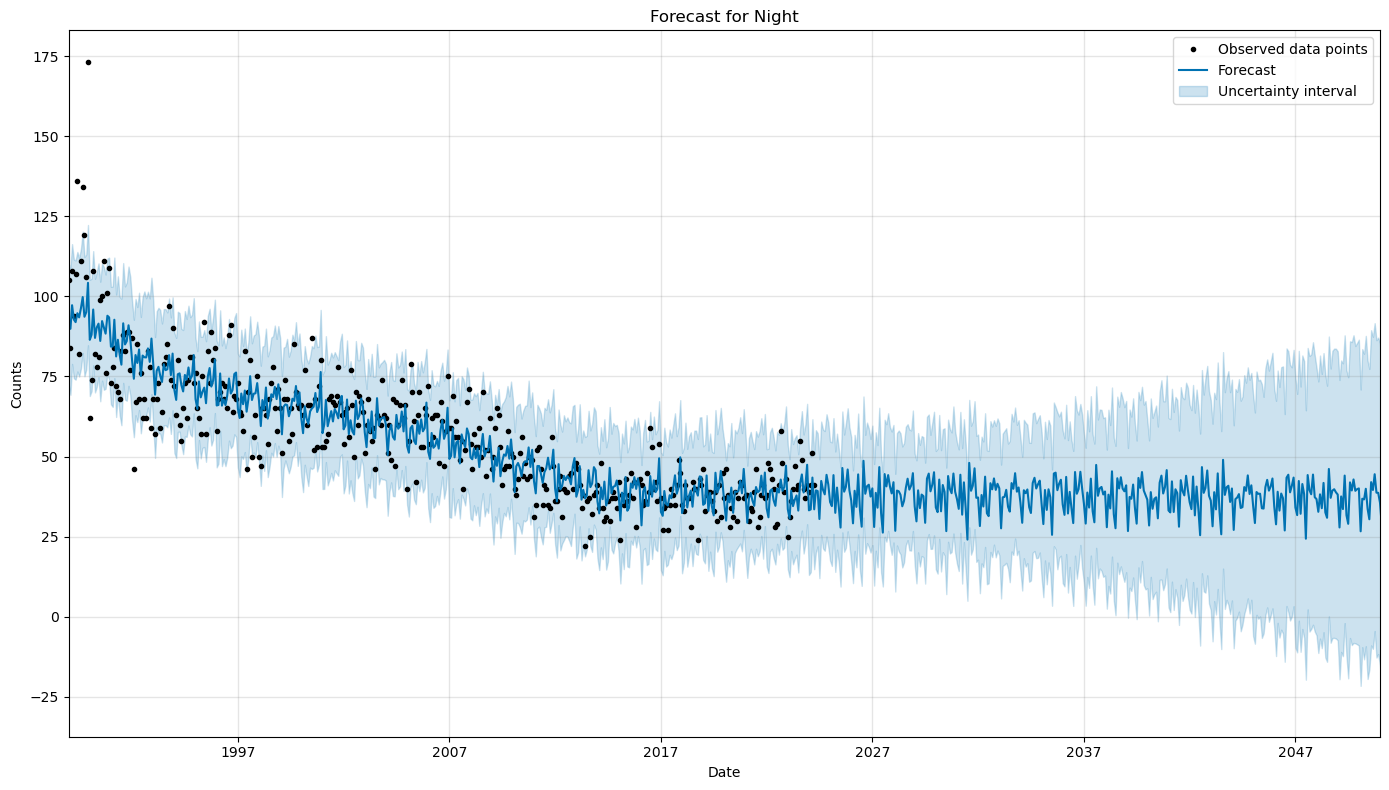

Dickey-Fuller Test Results:

Time of day: Day
ADF Statistic: -3.32
p-value: 0.01
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Time of day: Night
ADF Statistic: -5.34
p-value: 0.00
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Actual Counts per Year (2013-2023):
Year 2013: 1186.00 counts
Year 2014: 1150.00 counts
Year 2015: 1206.00 counts
Year 2016: 1292.00 counts
Year 2017: 1223.00 counts
Year 2018: 1135.00 counts
Year 2019: 1186.00 counts
Year 2020: 1097.00 counts
Year 2021: 1130.00 counts
Year 2022: 1180.00 counts
Year 2023: 1270.00 counts


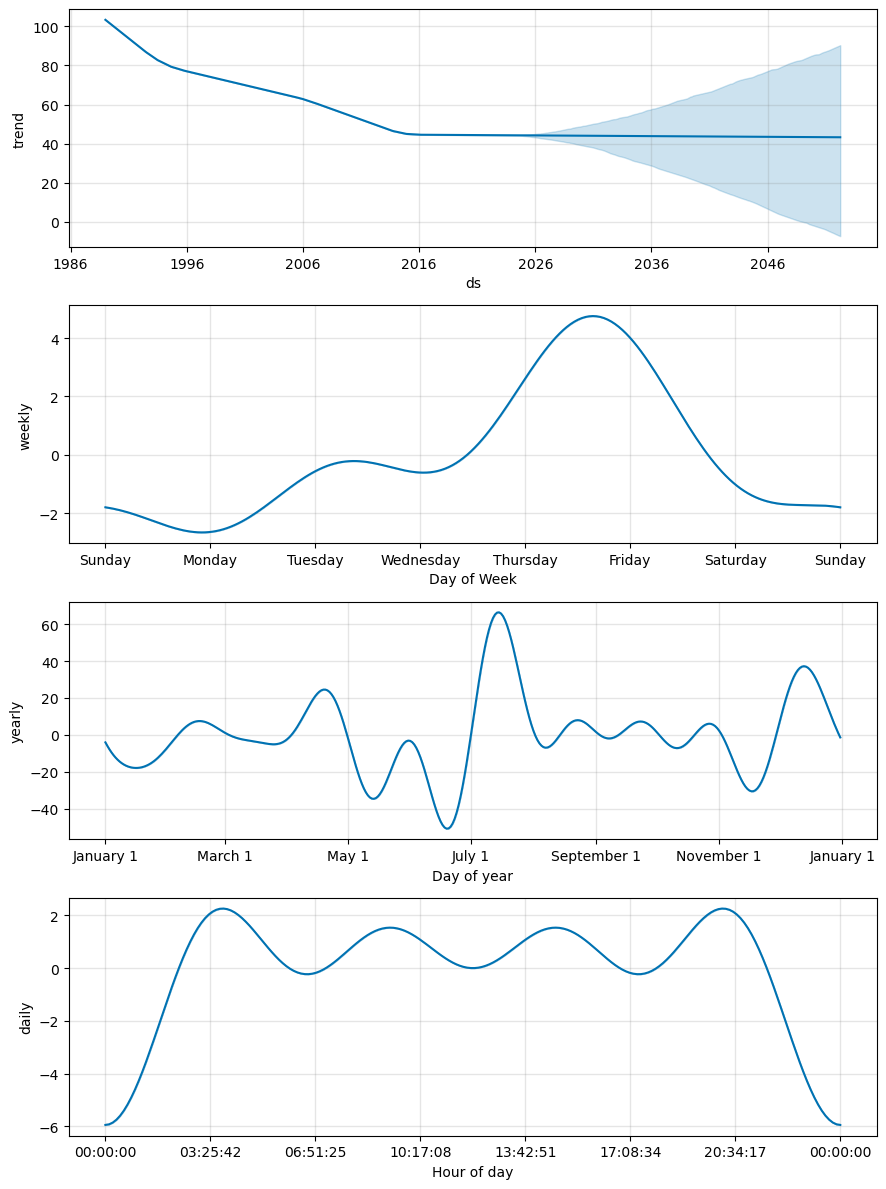

In [29]:
#without Holidays
#without Holidays
#without Holidays
#without Holidays
#without Holidays


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf



#
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})

        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive'
                        )
        model.fit(value_data)
        models[value] = model

        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

feature = 'Time of day' 
time_of_day_models, forecasts = forecast_feature(data, feature)

print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))

    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024.round(2))
    print()

    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]

    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print(f"Total fatalities predicted for {value} in 2030: {future_2030['yhat'].sum():.2f}")
    print()

    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print(f"Total fatalities predicted for {value} in 2040: {future_2040['yhat'].sum():.2f}")
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print(f"Total fatalities predicted for {value} in 2050: {future_2050['yhat'].sum():.2f}")
    print()

for value, forecast in forecasts.items():
    fig, ax = plt.subplots(figsize=(14, 8))
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # تنظیم محدوده محور x از سال 1989 تا 2050
    ax.set_xlim(pd.Timestamp('1989-01-01'), pd.Timestamp('2050-12-31'))
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

    # نمایش نمودار
    plt.tight_layout()
    plt.show()

print("Dickey-Fuller Test Results:")

for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\nTime of day: {value}")
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value:.2f}")


print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[data['Year'] == year].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum():.2f} counts")
fig = model.plot_components(forecast)


01:53:00 - cmdstanpy - INFO - Chain [1] start processing
01:53:00 - cmdstanpy - INFO - Chain [1] done processing
01:53:00 - cmdstanpy - INFO - Chain [1] start processing
01:53:00 - cmdstanpy - INFO - Chain [1] done processing


Evaluation Metrics for the Test Period (2023) - Time of day:
Day - MAE: 9.19, MSE: 128.36, MAPE: 13.56%
Forecast vs Actual for first three months of 2024 for Day:
            ds   yhat  yhat_lower  yhat_upper
420 2024-01-01  53.96       35.29       73.29
421 2024-02-01  72.83       54.85       90.80
422 2024-03-01  62.47       43.90       80.93
        Date  Counts
0 2024-01-01      59
1 2024-02-01      72
2 2024-03-01      62

Forecast for Day in 2030:
            ds   yhat  yhat_lower  yhat_upper
493 2030-01-31  43.92       25.22       62.70
494 2030-02-28  59.22       39.74       79.15
495 2030-03-31  49.24       29.26       67.45
496 2030-04-30  51.71       34.04       69.86
497 2030-05-31  51.85       32.31       69.80
498 2030-06-30  50.44       32.70       69.99
499 2030-07-31  47.83       28.06       66.45
500 2030-08-31  56.25       36.70       76.51
501 2030-09-30  51.67       33.96       70.99
502 2030-10-31  54.65       35.34       73.53
503 2030-11-30  59.70       41.57   

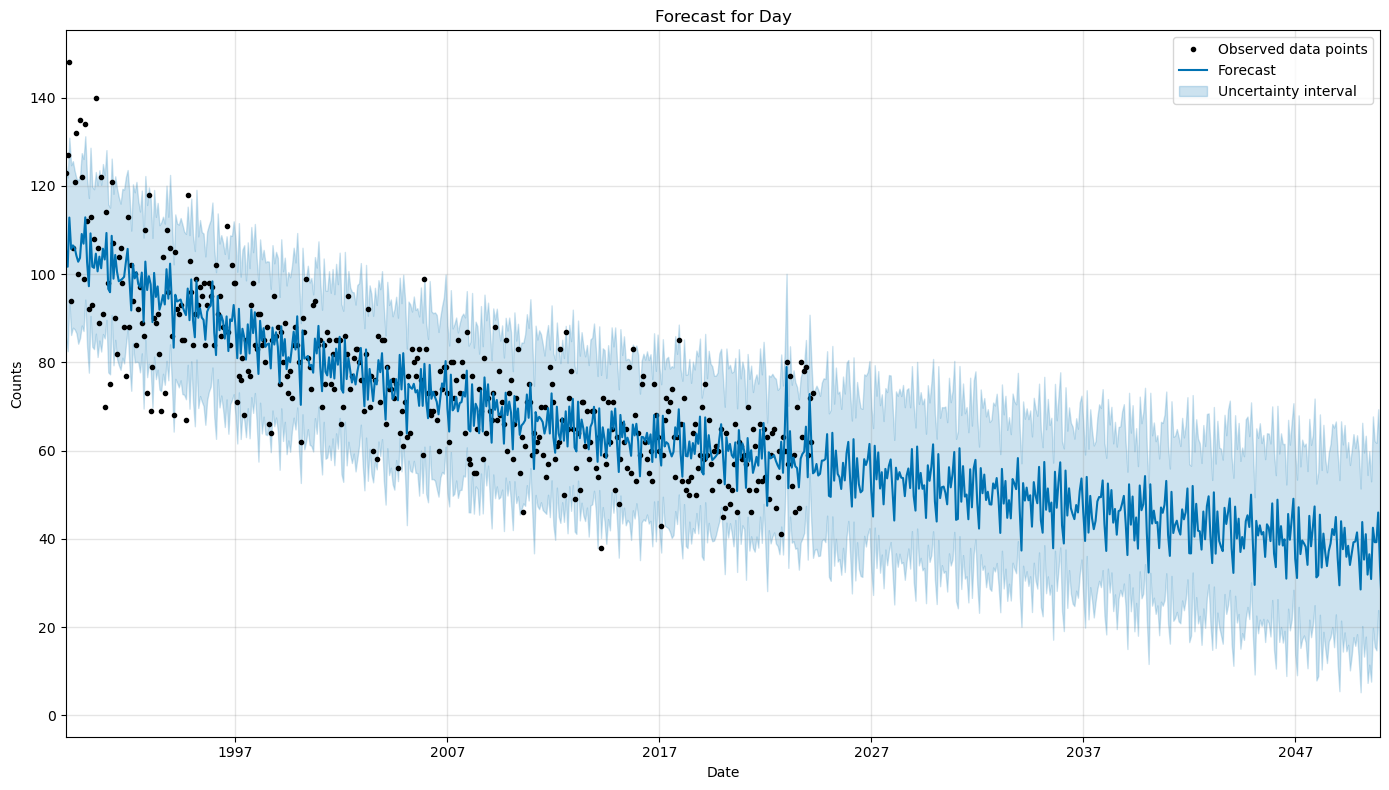

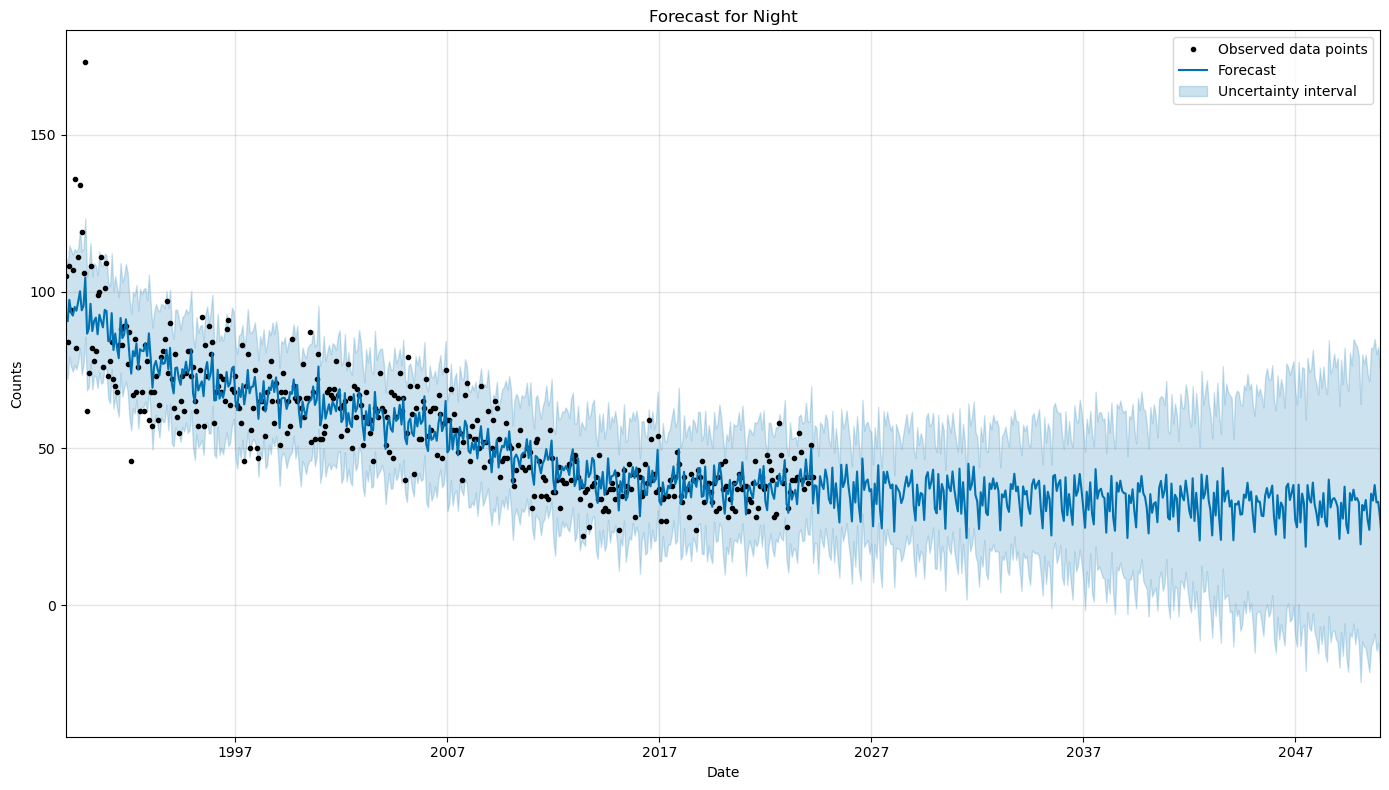

Dickey-Fuller Test Results:

Time of day: Day
ADF Statistic: -3.32
p-value: 0.01
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Time of day: Night
ADF Statistic: -5.34
p-value: 0.00
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Actual Counts per Year (2013-2023):
Year 2013: 1186.00 counts
Year 2014: 1150.00 counts
Year 2015: 1206.00 counts
Year 2016: 1292.00 counts
Year 2017: 1223.00 counts
Year 2018: 1135.00 counts
Year 2019: 1186.00 counts
Year 2020: 1097.00 counts
Year 2021: 1130.00 counts
Year 2022: 1180.00 counts
Year 2023: 1270.00 counts


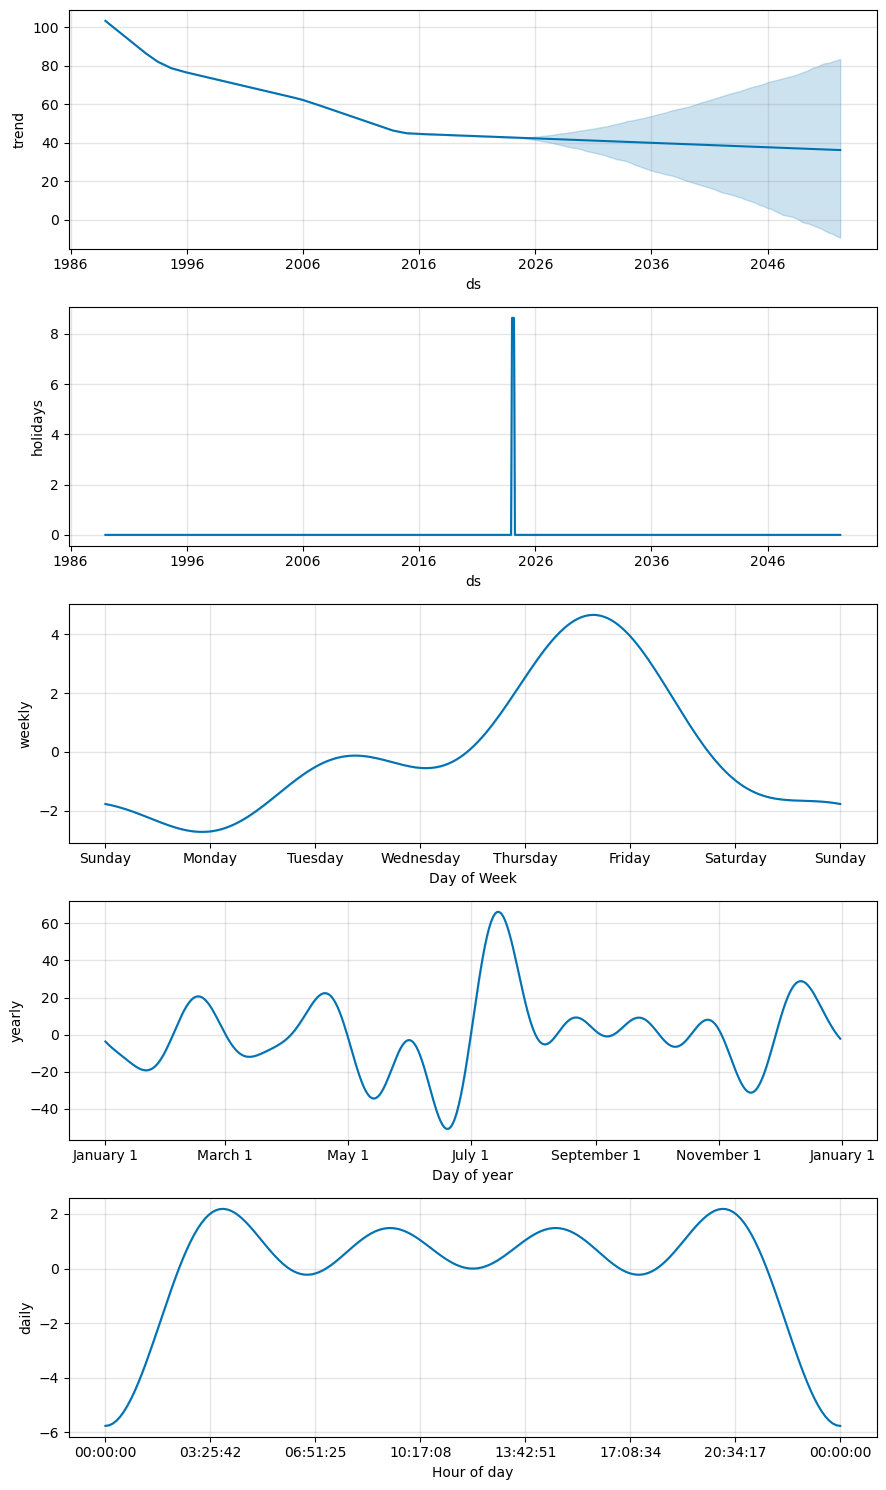

In [28]:
#with holidays 
#with holidays 
#with holidays 
#with holidays 
#with holidays 
#with holidays 
#with holidays 
#with holidays 



import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Define mean_absolute_percentage_error function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Assume `data` is already loaded as a DataFrame
# Ensure `Date` column is created correctly
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Split into train and test data
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Define custom holidays
night_holidays = pd.DataFrame({
    'holiday': 'night_shift_holidays',
    'ds': pd.to_datetime(['2024-03-01','2024-02-01','2024-01-01']),
    'lower_window': 0,
    'upper_window': 1,
})

day_holidays = pd.DataFrame({
    'holiday': 'day_shift_holidays',
    'ds': pd.to_datetime([ '2023-01-01', '2024-02-01', '2025-01-01']),
    'lower_window': 0,
    'upper_window': 1,
})

# Function to aggregate counts
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Function to forecast feature
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})

        if value == 'Night':
            holidays = night_holidays
        else:
            holidays = day_holidays

        model = Prophet(
            interval_width=0.95,
            yearly_seasonality=True,
            daily_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='additive',
            holidays=holidays
        )
        model.fit(value_data)
        models[value] = model

        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Define the feature and get forecasts
feature = 'Time of day'
time_of_day_models, forecasts = forecast_feature(data, feature)

print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))

    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024.round(2))
    print()

    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]

    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print(f"Total fatalities predicted for {value} in 2030: {future_2030['yhat'].sum():.2f}")
    print()

    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print(f"Total fatalities predicted for {value} in 2040: {future_2040['yhat'].sum():.2f}")
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print(f"Total fatalities predicted for {value} in 2050: {future_2050['yhat'].sum():.2f}")
    print()

# Plot forecasts for each time of day
for value, forecast in forecasts.items():
    fig, ax = plt.subplots(figsize=(14, 8))
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    ax.set_xlim(pd.Timestamp('1989-01-01'), pd.Timestamp('2050-12-31'))
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

    plt.tight_layout()
    plt.show()

# Dickey-Fuller Test Results
print("Dickey-Fuller Test Results:")

for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\nTime of day: {value}")
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, value in adf_result[4].items():
        print(f"Critical Value {key}: {value:.2f}")

# Actual counts per year
print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[data['Year'] == year].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum():.2f} counts")

# Plot components for a specific model
fig = time_of_day_models['Night'].plot_components(forecasts['Night'])
plt.show()
